# IR Unique Sequences EDA

#### Imports

In [1]:
# data science
from scipy.stats import norm
import numpy as np
import sqlite3 as sql
import pandas as pd

# utilities
from dotenv import load_dotenv
import os
from pathlib import Path
from termcolor import colored
from tqdm import tqdm
import gzip
import math

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
import upsetplot
from upsetplot import UpSet
from upsetplot import plot
from wordcloud import WordCloud

load_dotenv("paths.env")

True

In [18]:
domains = ["Archaea", "Eukaryota", "Bacteria", "Viruses"]
domain_colors = {
                 'Viruses': '#6bb5c7',
                 'Eukaryota': '#e69c3c',
                 'Archaea': '#b2b2ff',
                 'Bacteria': '#a3c4a3'
            }

kingdom_color_palette = {
                         "Viruses": "#6bb5c7",
                         "Bacteria": "#0fbf2d",
                         "Archaea": "#b2b2ff",
                         "Fungi": "#4d325e",
                         "Plantae": "#b50996",
                         "Eubacteria": "#0fbf2d",
                         "Animalia": "#9bba2d",
                         "Protista": "#c78f5b",
                         "Archaeabacteria": "#7b7bed",
                } 

In [19]:
load_dotenv("paths.env")
DATABASE = os.getenv("DATABASE")
IRP_DB = os.getenv("IRP_DB")
EMPTY_ASSEMBLIES_PATH = os.getenv("EMPTY_ASSEMBLIES")

assert os.path.isdir(DATABASE), "Invalid directory!"
assert os.path.isfile(IRP_DB), "Invalid inverted repeats database."
assert os.path.isfile(EMPTY_ASSEMBLIES_PATH), "Invalid empty assemblies db."

In [20]:
irp_df = pd.read_parquet("/storage/group/izg5139/default/external/satellites/scripts/enrichment/inverted_repeats/tree_of_life_inverted_repeats.parquet.snappy")
irp_df.head()

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,composition,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,gc_content,at_content
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,4A/0C/2G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,2,8
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,4A/0C/0G/6T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0,10
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,3A/3C/0G/5T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,3,8
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,7A/0C/0G/3T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0,10
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,3A/3C/1G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,4,7


In [34]:
irp_df.shape

(29589132, 24)

In [21]:
irp_df = irp_df[irp_df['superkingdom'].isin({"Eukaryota", "Archaea", "Bacteria", "Viruses"})].reset_index(drop=True)
irp_df.head()

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,composition,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,gc_content,at_content
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,4A/0C/2G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,2,8
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,4A/0C/0G/6T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0,10
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,3A/3C/0G/5T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,3,8
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,7A/0C/0G/3T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0,10
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,3A/3C/1G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,4,7


In [22]:
irp_df = irp_df[irp_df["spacerLength"] < 9]

# Venn Diagram

In [23]:
irp_df.head()

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,composition,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,gc_content,at_content
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,4A/0C/2G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,2,8
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,4A/0C/0G/6T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0,10
2,AE009951.2,47710,47740,cttctaatact,acatcaca,cttctaatactacatcacaagtattagaag,11,8,30,3,...,3A/3C/0G/5T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,3,8
3,AE009951.2,65000,65024,attataaaaa,ccat,attataaaaaccattttttataat,10,4,24,7,...,7A/0C/0G/3T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0,10
4,AE009951.2,76290,76316,atacccttgat,agaa,atacccttgatagaaatcaagggtat,11,4,26,3,...,3A/3C/1G/4T,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,4,7


In [31]:
irp_counts_total = irp_df.groupby("sequenceOfArm")\
                         .agg({"#assembly_accession": "count",
                              "armLength": "first",
                              "superkingdom": lambda ds: set(ds.tolist())
                             })
irp_counts_total

,#assembly_accession,armLength,superkingdom
sequenceOfArm,,,
aaaaaaaaaa,4599,10,"{Viruses, Bacteria, Eukaryota}"
aaaaaaaaaaa,1453,11,"{Viruses, Bacteria, Eukaryota}"
aaaaaaaaaaaa,684,12,"{Bacteria, Eukaryota}"
aaaaaaaaaaaaa,371,13,"{Viruses, Bacteria, Eukaryota}"
aaaaaaaaaaaaaa,184,14,"{Viruses, Eukaryota}"
...,...,...,...
tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttta,1,63,{Eukaryota}
tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttta,1,73,{Eukaryota}
tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttaatttt,1,83,{Eukaryota}


In [32]:
irp_counts_total.loc[:, "length"] = irp_counts_total["superkingdom"].apply(len)

In [33]:
irp_counts_total = irp_counts_total.rename(columns={"#assembly_accession": "counts"})
irp_counts_total.head()

,counts,armLength,superkingdom,length
sequenceOfArm,,,,
aaaaaaaaaa,4599,10,"{Viruses, Bacteria, Eukaryota}",3
aaaaaaaaaaa,1453,11,"{Viruses, Bacteria, Eukaryota}",3
aaaaaaaaaaaa,684,12,"{Bacteria, Eukaryota}",2
aaaaaaaaaaaaa,371,13,"{Viruses, Bacteria, Eukaryota}",3
aaaaaaaaaaaaaa,184,14,"{Viruses, Eukaryota}",2


In [35]:
irp_counts_total.sort_values(by=['counts'], ascending=False).head(5)

,counts,armLength,superkingdom,length
sequenceOfArm,,,,
atatatatat,83669,10,"{Archaea, Viruses, Bacteria, Eukaryota}",4
tatatatata,76045,10,"{Archaea, Viruses, Bacteria, Eukaryota}",4
atatatatata,67786,11,"{Archaea, Viruses, Bacteria, Eukaryota}",4
tatatatatat,60749,11,"{Archaea, Viruses, Bacteria, Eukaryota}",4
atatatatatat,54379,12,"{Archaea, Viruses, Bacteria, Eukaryota}",4


In [36]:
irp_df.loc[:, "hashed_sequence"] = irp_df.sequenceOfArm.apply(hash)
irp_df.head(2)

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,gc_content,at_content,hashed_sequence
0,AE009951.2,17161,17183,gtaaaagttt,ct,gtaaaagtttctaaacttttac,10,2,22,4,...,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,2,8,4925449227186885393
1,AE009951.2,26386,26407,ttaatatatt,t,ttaatatatttaatatattaa,10,1,21,4,...,GCA_000007325.1,27.0,Fusobacterium nucleatum subsp. nucleatum ATCC ...,Fusobacteriota,Eubacteria,Bacteria,2174500,0,10,3800317221746111578


In [37]:
sequences_per_group = irp_df.groupby("superkingdom")\
                        .agg({"hashed_sequence": lambda x: set(x.unique())})\
                        .hashed_sequence\
                        .to_dict()

In [38]:
list(sequences_per_group.keys())

['Archaea', 'Bacteria', 'Eukaryota', 'Viruses']

In [ ]:
from venny4py.venny4py import *

# fig, ax = plt.subplots(nrows=1, ncols=1, dpi=160, size=2)
venny4py(sets=sequences_per_group, size=3)
plt.gcf().savefig(f"{DATABASE}/superkingdom_venn_intersection.png", bbox_inches='tight')
plt.gcf().savefig(f"{DATABASE}/superkingdom_venn_intersection.pdf", format="pdf", bbox_inches='tight')

# Upset it!

In [57]:
!mv ../TandemRepeats /storage/group/izg5139/default/nicole

In [7]:
DATABASE

'/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures'

In [39]:
grouped_genome_size = irp_df.groupby("sequenceOfArm").agg(
                                                          total_arm=("armLength", "first"), 
                                                          total_gap=("spacerLength", "sum"),
                                                          gap_unique=("spacerLength", lambda ds: set(ds.tolist())),
                                                          total_counts=("kingdom", "count"),
                                                          superkingdom=("superkingdom", lambda ds: set(ds.tolist())),
                                    )\
                            .sort_values(by=['total_counts'], ascending=False)

grouped_genome_size

,total_arm,total_gap,gap_unique,total_counts,superkingdom
sequenceOfArm,,,,,
atatatatat,10,61870,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",83668,"{Archaea, Viruses, Bacteria, Eukaryota}"
tatatatata,10,56304,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",76045,"{Archaea, Viruses, Bacteria, Eukaryota}"
atatatatata,11,40442,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",67785,"{Archaea, Viruses, Bacteria, Eukaryota}"
tatatatatat,11,36290,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",60748,"{Archaea, Viruses, Bacteria, Eukaryota}"
atatatatatat,12,25579,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",54379,"{Archaea, Viruses, Bacteria, Eukaryota}"
...,...,...,...,...,...
ttgataaaagcatgaaac,18,5,{5},0,{Viruses}
ttgaggttttattaaaat,18,24,{8},0,{Viruses}
ttgaattatcatttaatta,19,6,{6},0,{Viruses}


In [40]:
grouped_genome_size = grouped_genome_size.sort_values(by=['total_counts'], ascending=False)\
                        .assign(arm_size=lambda df: df.index.map(len))\
                        .assign(gap_diversity=lambda df: df['gap_unique'].apply(len))

grouped_genome_size

,total_arm,total_gap,gap_unique,total_counts,superkingdom,arm_size,gap_diversity
sequenceOfArm,,,,,,,
atatatatat,10,61870,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",83668,"{Archaea, Viruses, Bacteria, Eukaryota}",10,9
tatatatata,10,56304,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",76045,"{Archaea, Viruses, Bacteria, Eukaryota}",10,9
atatatatata,11,40442,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",67785,"{Archaea, Viruses, Bacteria, Eukaryota}",11,9
tatatatatat,11,36290,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",60748,"{Archaea, Viruses, Bacteria, Eukaryota}",11,9
atatatatatat,12,25579,"{0, 1, 2, 3, 4, 5, 6, 7, 8}",54379,"{Archaea, Viruses, Bacteria, Eukaryota}",12,9
...,...,...,...,...,...,...,...
acatttggtttttt,14,6,{6},0,{Viruses},14,1
aatgagagagaata,14,14,{7},0,{Viruses},14,1
tgtttgataaat,12,12,{6},0,{Viruses},12,1


In [41]:
domains = ["Eukaryota", "Archaea", "Bacteria", "Viruses"]

for domain in domains:
    grouped_genome_size.loc[:, domain] = grouped_genome_size['superkingdom'].apply(lambda d: domain in d)

In [42]:
grouped_genome_size.loc[:, 'gap_diversity'] = grouped_genome_size['gap_diversity'].apply(lambda x: x/9)

/tmp/ipykernel_1206901/89627649.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         1.         1.         ... 0.11111111 0.11111111 0.11111111]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  grouped_genome_size.loc[:, 'gap_diversity'] = grouped_genome_size['gap_diversity'].apply(lambda x: x/9)


In [43]:
upset_domains = grouped_genome_size.groupby(list(domains))\
                                    .agg({
                                          "arm_size": "mean", 
                                          "gap_diversity": "mean",
                                          "total_arm": "count",
                                         }
                                    )\
                                    .rename(
                                            columns={
                                                    "arm_size": "Mean Arm Length", 
                                                     "gap_diversity": "Spacer Diversity"
                                                }
                                        )\
                            .sort_values(by=['total_arm'], ascending=False)\
                            .assign(intersection=lambda x: x['total_arm'].apply(lambda y: math.log(y+1, 10)))
                            # .assign(proportion=lambda x: x['total_arm'].div(total_unique_sequences))
    
upset_domains

Mean Arm Length  Spacer Diversity  \
Eukaryota Archaea Bacteria Viruses                                      
False     False   True     False          14.543661          0.134826   
True      False   False    False          14.948990          0.131188   
                  True     False          10.464147          0.361810   
False     False   False    True           14.716497          0.112511   
          True    False    False          12.542376          0.113179   
                  True     False          10.406294          0.385594   
          False   True     True           10.954724          0.340438   
True      False   True     True           10.417630          0.630503   
          True    True     False          10.238436          0.644517   
          False   False    True           11.064490          0.294350   
          True    False    False          10.471466          0.282730   
                  True     True           10.251863          0.916984   
False     True    True     True           10.146993          0.590695   
                  False    True           10.536232          0.207729   
True      True    False    True           10.410714          0.450397   

                                    total_arm  intersection  
Eukaryota Archaea Bacteria Viruses                           
False     False   True     False      2518233      6.401096  
True      False   False    False       781848      5.893123  
                  True     False       187783      5.273659  
False     False   False    True         26423      4.421999  
          True    False    False        19398      4.287779  
                  True     False        14364      4.157306  
          False   True     True         11463      4.059336  
True      False   True     True          8735      3.941313  
          True    True     False         7956      3.900749  
          False   False    True          3768      3.576226  
          True    False    False         2681      3.428459  
                  True     True          2013      3.304059  
False     True    True     True           449      2.653213  
                  False    True            69      1.845098  
True      True    False    True            56      1.755875

In [44]:
import warnings
warnings.filterwarnings('ignore') 

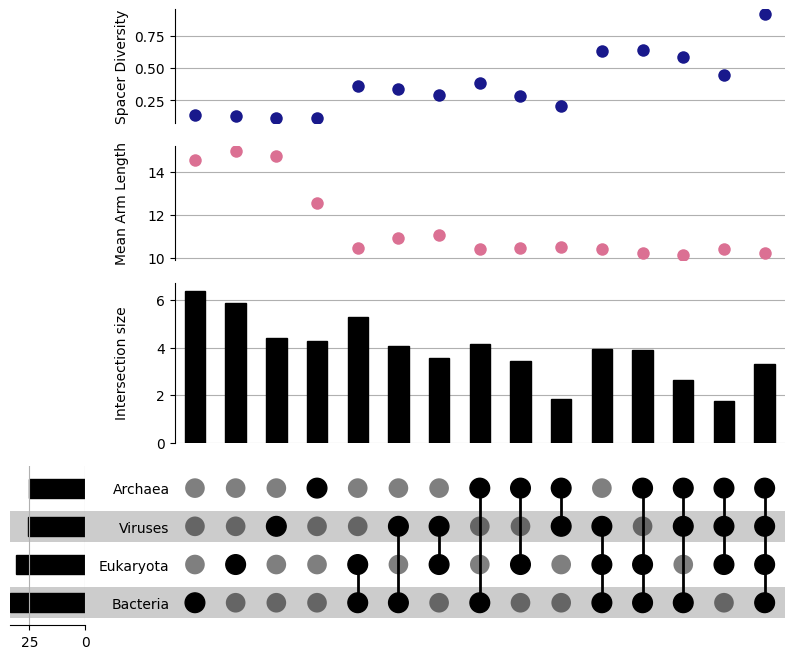

In [45]:
# UpSet plot it!

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
upset = UpSet(upset_domains,# .assign(proportion=lambda ds: ds['proportion'].apply(lambda y: math.log(y+1, 10))), 
                subset_size="sum", 
              # facecolor='#5B5959', 
              sum_over="intersection", 
              intersection_plot_elements=4, 
              element_size=None,
              other_dots_color=0.5,
              shading_color=0.2,
             )

# upset.style_subsets(present=["Bacteria"],
#                    facecolor=domain_colors["Bacteria"],
#                    edgecolor="black"
#                       )
    
# upset.style_subsets(present=["Eukaryota"],
#                        absent=["Bacteria"],
#                    facecolor=domain_colors["Eukaryota"],
#                    edgecolor="black"
#                       )
# upset.style_subsets(present=["Archaea"],
#                        absent=["Bacteria", "Eukaryota"],
#                    facecolor=domain_colors["Archaea"],
#                    edgecolor="black"
#                       )
# upset.style_subsets(present=["Viruses"],
 #                       absent=["Bacteria", "Eukaryota", "Archaea"],
 #                   facecolor=domain_colors["Viruses"],
 #                   edgecolor="black"
 #                      )


upset.add_catplot(value="Mean Arm Length", kind="strip", color="#DB7093", alpha=1.0, size=9)
upset.add_catplot(value="Spacer Diversity", kind="strip", color="navy", alpha=0.9, size=9)
upset.plot(fig=fig)
ax.axis("off")
ax.legend(handles=[], frameon=False)
plt.savefig(f"{DATABASE}/upset_intersections.png", format="png", bbox_inches='tight')
plt.show()

In [47]:
f"{DATABASE}/upset_intersections.png"

'/storage/group/izg5139/default/nicole/inverted_repeats/paper_graphs/final_figures/upset_intersections.png'

# Taxonomic Inverted Repeats (Unique)

In [11]:
irp_counts = irp_df.groupby("sequenceOfArm")\
                        .agg({"#assembly_accession": "nunique",
                              "armLength": "first",
                             "superkingdom": "unique"
                             })\
                    .assign(length=lambda df: df['superkingdom'].apply(len)
                           )
irp_counts

,#assembly_accession,armLength,superkingdom,length
sequenceOfArm,,,,
aaaaaaaaaa,204,10,"[Bacteria, Eukaryota, Viruses]",3
aaaaaaaaaaa,91,11,"[Bacteria, Eukaryota, Viruses]",3
aaaaaaaaaaaa,62,12,"[Eukaryota, Bacteria]",2
aaaaaaaaaaaaa,35,13,"[Eukaryota, Viruses, Bacteria]",3
aaaaaaaaaaaaaa,25,14,"[Eukaryota, Viruses]",2
...,...,...,...,...
tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttta,1,63,[Eukaryota],1
tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttta,1,73,[Eukaryota],1
tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttaatttt,1,83,[Eukaryota],1


In [12]:
total_species_unique = irp_df['#assembly_accession'].nunique()
total_species_unique

84922

In [13]:
for domain in tqdm(domains):
    irp_counts.loc[:, domain] = irp_counts["superkingdom"].apply(lambda g: domain in g)

irp_counts.head()

100%|██████████| 4/4 [00:54<00:00, 13.69s/it]


,#assembly_accession,armLength,superkingdom,length,Archaea,Eukaryota,Bacteria,Viruses
sequenceOfArm,,,,,,,,
aaaaaaaaaa,204,10,"[Bacteria, Eukaryota, Viruses]",3,False,True,True,True
aaaaaaaaaaa,91,11,"[Bacteria, Eukaryota, Viruses]",3,False,True,True,True
aaaaaaaaaaaa,62,12,"[Eukaryota, Bacteria]",2,False,True,True,False
aaaaaaaaaaaaa,35,13,"[Eukaryota, Viruses, Bacteria]",3,False,True,True,True
aaaaaaaaaaaaaa,25,14,"[Eukaryota, Viruses]",2,False,True,False,True


In [14]:
taxonomic_irp = irp_counts[irp_counts['length'] == 1].query("armLength < 11")
taxonomic_irp.loc[:, "superkingdom"] = taxonomic_irp["superkingdom"].apply(lambda x: x[0])
taxonomic_irp.head()

,#assembly_accession,armLength,superkingdom,length,Archaea,Eukaryota,Bacteria,Viruses
sequenceOfArm,,,,,,,,
aaaaaaacgt,1,10,Bacteria,1,False,False,True,False
aaaaaaagcg,569,10,Bacteria,1,False,False,True,False
aaaaaacacg,20,10,Bacteria,1,False,False,True,False
aaaaaacccc,195,10,Bacteria,1,False,False,True,False
aaaaaacccg,129,10,Bacteria,1,False,False,True,False


In [21]:
irp_df.shape

(29589132, 23)

In [36]:
irp_df[irp_df['sequenceOfArm'] == 'cgttattggt'].shape

(10817, 23)

In [37]:
taxonomic_irp[taxonomic_irp.index == 'cgttattggt']

,#assembly_accession,armLength,superkingdom,length,Archaea,Eukaryota,Bacteria,Viruses
sequenceOfArm,,,,,,,,
cgttattggt,10601,10,Bacteria,1,False,False,True,False


In [23]:
def generate_cloud(extracted_text, taxonomy=None, ax=None):
    if isinstance(extracted_text, list):
        extracted_text_rejoined = ' '.join(extracted_text)

    wordcloud = WordCloud(width=300, height=200,
                        background_color='white',
                        min_font_size=5,
                        collocations = False,
                          contour_width=3
                          )\
                    .generate(extracted_text_rejoined)

    # fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120)
    ax = plt.gca()
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(taxonomy.capitalize())
    ax.title.set_size(20)
    return plt.gcf() # fig

In [35]:
from collections import Counter

Counter(extracted_text).most_common(5)

[('acgagcagag', 311),
 ('ctgctctgag', 245),
 ('gcatgtgggg', 239),
 ('gattggacag', 193),
 ('agggataaac', 178)]

Archaea


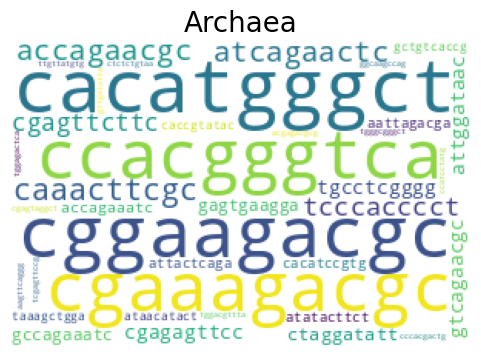

Eukaryota


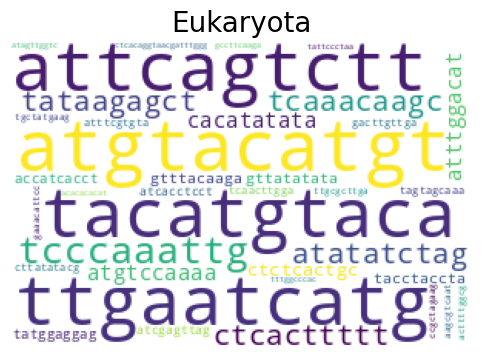

Bacteria


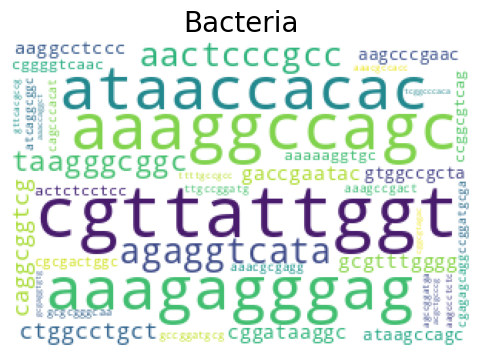

Viruses


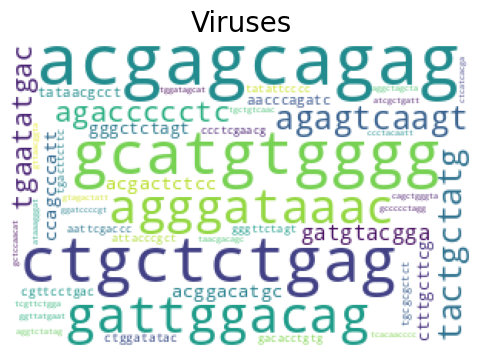

In [38]:
for idx, domain in enumerate(domains):
    group_cloud = taxonomic_irp[taxonomic_irp["superkingdom"] == domain].query("armLength < 11").reset_index()
    arm_counts = group_cloud[["sequenceOfArm", "#assembly_accession"]].set_index("sequenceOfArm")["#assembly_accession"].to_dict()
    extracted_text = []
    for key, value in arm_counts.items():
        extracted_text.extend([key] * value)
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    fig = generate_cloud(extracted_text, domain, ax=ax)
    print(domain)
    plt.show()
    target = Path(f"{DATABASE}/wordclouds")
    target.mkdir(exist_ok=True)
    fig.savefig(f"{target}/taxonomic_cloud_irp_{domain}.png", bbox_inches='tight')
    # fig.savefig(f"{DATABASE}/taxonomic_cloud_irp_{domain}.pdf", bbox_inches='tight', format="pdf")
    plt.close()
    # aaacacacgg

In [43]:
archaea = irp_df[(irp_df['superkingdom'] == 'Archaea') | (irp_df['superkingdom'] == 'Viruses')]
archaea

,seqID,start,end,sequenceOfArm,sequenceOfSpacer,sequence,armLength,spacerLength,sequenceLength,arm_a,...,composition,#assembly_accession,gc_percent,organism_name,phylum,kingdom,superkingdom,genome_size,gc_content,at_content
2055,AE017199.1,31270,31293,ttgttataat,gga,ttgttataatggaattataacaa,10,3,23,3,...,3A/0C/1G/6T,GCA_000008085.1,31.5,Nanoarchaeum equitans Kin4-M,Nanoarchaeota,Archaeabacteria,Archaea,490885,1,9
2056,AE017199.1,56058,56081,ttggtttttt,cgc,ttggttttttcgcaaaaaaccaa,10,3,23,0,...,0A/0C/2G/8T,GCA_000008085.1,31.5,Nanoarchaeum equitans Kin4-M,Nanoarchaeota,Archaeabacteria,Archaea,490885,2,8
2057,AE017199.1,144884,144909,tatatatttg,ccatt,tatatatttgccattcaaatatata,10,5,25,3,...,3A/0C/1G/6T,GCA_000008085.1,31.5,Nanoarchaeum equitans Kin4-M,Nanoarchaeota,Archaeabacteria,Archaea,490885,1,9
2058,AE017199.1,207853,207877,ctttagcaaaag,.,ctttagcaaaagcttttgctaaag,12,0,24,5,...,5A/2C/2G/3T,GCA_000008085.1,31.5,Nanoarchaeum equitans Kin4-M,Nanoarchaeota,Archaeabacteria,Archaea,490885,4,8
2059,AE017199.1,257019,257040,ttatagtaat,t,ttatagtaattattactataa,10,1,21,4,...,4A/0C/1G/5T,GCA_000008085.1,31.5,Nanoarchaeum equitans Kin4-M,Nanoarchaeota,Archaeabacteria,Archaea,490885,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29575299,NZ_OY787453.1,1776368,1776391,ctcagaaaac,ggg,ctcagaaaacggggttttctgag,10,3,23,5,...,5A/3C/1G/1T,GCF_963678795.1,52.5,uncultured Methanoregula sp.,Euryarchaeota,Archaeabacteria,Archaea,3113664,4,6
29575300,NZ_OY787453.1,1820948,1820970,tcctccgggac,.,tcctccgggacgtcccggagga,11,0,22,1,...,1A/5C/3G/2T,GCF_963678795.1,52.5,uncultured Methanoregula sp.,Euryarchaeota,Archaeabacteria,Archaea,3113664,8,3
29575301,NZ_OY787453.1,1880584,1880607,cattgccggc,gag,cattgccggcgaggccggcaatg,10,3,23,1,...,1A/4C/3G/2T,GCF_963678795.1,52.5,uncultured Methanoregula sp.,Euryarchaeota,Archaeabacteria,Archaea,3113664,7,3
29575302,NZ_OY787453.1,1927787,1927810,gcagcagtca,tgg,gcagcagtcatggtgactgctgc,10,3,23,3,...,3A/3C/3G/1T,GCF_963678795.1,52.5,uncultured Methanoregula sp.,Euryarchaeota,Archaeabacteria,Archaea,3113664,6,4


In [44]:
archaea['phylum'].nunique()

32

In [46]:
irp_df.shape

(29589132, 23)

In [113]:
irp_df_phylum_rel = irp_df[irp_df['armLength'] == 10].groupby("phylum")\
                                .agg({"sequenceOfArm": lambda ds: set(ds.tolist()),
                                     "superkingdom": "first"})
irp_df_phylum_rel

,sequenceOfArm,superkingdom
phylum,,
Abditibacteriota,"{aacccgccat, aaagccaccc, gtagaacaga, aaagtcgcc...",Bacteria
Acidobacteriota,"{cggtcgacga, ccccaggaac, ggccggcttg, caggccgac...",Bacteria
Actinomycetota,"{cgggatgggc, ctttggggtc, cgccaattct, cagctcgcg...",Bacteria
Apicomplexa,"{aaactttata, acatgactgg, ttaaataaat, atatccatt...",Eukaryota
Aquificota,"{ctctatggca, tttttccttc, gtaaaacttc, acataaagt...",Bacteria
...,...,...
Verrucomicrobiota,"{acgcgggcag, ggaagcggga, aagcccttcc, aaagccacc...",Bacteria
Vulcanimicrobiota,"{tcgacctcgg, taaagaatga, agggggagat, ctgacgcgc...",Bacteria
candidate division NC10,"{gaatcttctc, caccctcttc, cctccctttg, gccgatgat...",Bacteria


In [114]:
from itertools import combinations

In [115]:
phylums = irp_df_phylum_rel.index.tolist()

In [116]:
len([com for com in combinations(phylums, 2)])

8001

In [117]:
phylum_combinations = [com for com in combinations(phylums, 2) if com[0] != com[1]]
len(phylum_combinations)

8001

In [118]:
phylum_combinations[0]

('Abditibacteriota', 'Acidobacteriota')

In [126]:
phylum_colors = irp_df_phylum_rel['superkingdom'].map(domain_colors).to_dict()
phylum_colors

with open("phylums.txt", mode="w") as f:
    for key, value in phylum_colors.items():
        f.write(f"{key}\t{value}\n")

In [123]:
from tqdm import tqdm
from collections import defaultdict
relationships = []
for phylum_pair in tqdm(phylum_combinations, leave=True, position=0):

    first, second = phylum_pair
    first_collection = irp_df_phylum_rel.loc[first, 'sequenceOfArm']
    second_collection = irp_df_phylum_rel.loc[second, 'sequenceOfArm']
    

    relationship_strength = len(first_collection.intersection(second_collection)) / len(first_collection.union(second_collection))
    common = len(first_collection.intersection(second_collection))

    relationships.append({
                          "phylum_A": first, 
                          "phylum_B": second, 
                          "common": common,
                          "jaccard": relationship_strength,
                         })

100%|██████████| 8001/8001 [00:07<00:00, 1086.88it/s]


In [124]:
relationships_df = pd.DataFrame(relationships)
relationships_df

,phylum_A,phylum_B,common,jaccard
0,Abditibacteriota,Acidobacteriota,7,0.000805
1,Abditibacteriota,Actinomycetota,33,0.000318
2,Abditibacteriota,Apicomplexa,0,0.000000
3,Abditibacteriota,Aquificota,0,0.000000
4,Abditibacteriota,Armatimonadota,0,0.000000
...,...,...,...,...
7996,Vulcanimicrobiota,candidate division WWE3,0,0.000000
7997,Vulcanimicrobiota,candidate division Zixibacteria,0,0.000000
7998,candidate division NC10,candidate division WWE3,0,0.000000
7999,candidate division NC10,candidate division Zixibacteria,0,0.000000


In [125]:
relationships_df.to_csv("relationships.txt.gz", compression="gzip", sep="\t", index=False, mode="w")

In [101]:
relationships_df["jaccard"].apply(pd.Series)

,0,1
0,8.0,0.000346
1,47.0,0.000072
2,0.0,0.000000
3,0.0,0.000000
4,0.0,0.000000
...,...,...
6323,0.0,0.000000
6324,0.0,0.000000
6325,0.0,0.000000
6326,0.0,0.000000


In [99]:
relationships_df = pd.concat([relationships_df.drop(columns=["jaccard"]),
                              relationships_df["jaccard"].apply(pd.Series)
                             ], axis=0)
relationships_df

,phylum_A,phylum_B,0,1
0,Abditibacteriota,Acidobacteriota,NaN,NaN
1,Abditibacteriota,Actinomycetota,NaN,NaN
2,Abditibacteriota,Aquificota,NaN,NaN
3,Abditibacteriota,Armatimonadota,NaN,NaN
4,Abditibacteriota,Artverviricota,NaN,NaN
...,...,...,...,...
6323,NaN,NaN,0.0,0.0
6324,NaN,NaN,0.0,0.0
6325,NaN,NaN,0.0,0.0
6326,NaN,NaN,0.0,0.0


In [92]:
relationships_df.sort_values(by=['jaccard'], ascending=False)

,phylum_A,phylum_B,jaccard
315,Actinomycetota,Pseudomonadota,0.059785
850,Bacillota,Pseudomonadota,0.051369
763,Bacillota,Bacteroidota,0.047076
1446,Campylobacterota,Mycoplasmatota,0.046131
954,Bacteroidota,Pseudomonadota,0.040995
...,...,...,...
4166,Candidatus Peregrinibacteria,Rhodothermota,0.000000
4167,Candidatus Peregrinibacteria,Saleviricota,0.000000
4170,Candidatus Peregrinibacteria,Taleaviricota,0.000000
2252,Candidatus Cloacimonadota,Candidatus Odinarchaeota,0.000000
